### Tugas Individu: Eksplorasi Autoencoder
### Pemodelan Representasi Laten Wajah Menggunakan Variational Autoencoder (VAE) Pada Dataset Selebritis Dunia
- NIM: 442023611088
- Nama: Fayshal Karan Athilla
- Kelas: Teknik Informatika 5 / A1

### IMPORT LIBRARY YANG DIPERLUKAN

In [27]:
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CelebA

import torch
from torch.utils.data import DataLoader
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

### MENYIAPKAN DATASET

In [28]:
#path dataset dari kaggle
data_dir = "/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba"

In [29]:
#dataset custom sederhana
class CelebADataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.file_list = [f for f in os.listdir(root_dir) if f.endswith(('.jpg', '.png'))][:10000]
 # ambil subset 10k
        self.transform = transform

    def __len__(self):
        return len(self.file_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.file_list[idx])
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, 0  # label dummy

In [30]:
#transformasi
transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.5]*3, [0.5]*3)
])

dataset = CelebADataset(data_dir, transform=transform)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

### ARSITEKTUR VARIATIONAL AUTOENCODER (VAE)

In [43]:
import torch.nn as nn
import torch.nn.functional as F

class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, 2, 1),  # 64x64 → 32x32
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1),  # 32x32 → 16x16
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1),  # 16x16 → 8x8
            nn.ReLU(),
            nn.Flatten()
        )
        self.fc_mu = nn.Linear(128 * 8 * 8, latent_dim)
        self.fc_logvar = nn.Linear(128 * 8 * 8, latent_dim)
        
        # Decoder
        self.decoder_input = nn.Linear(latent_dim, 128 * 8 * 8)
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(128, 64, 4, 2, 1),  # 8x8 → 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # 16x16 → 32x32
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, 2, 1),  # 32x32 → 64x64
            nn.Tanh()  # karena kita normalisasi antara -1 dan 1
        )

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        encoded = self.encoder(x)
        mu = self.fc_mu(encoded)
        logvar = self.fc_logvar(encoded)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decoder_input(z).view(-1, 128, 8, 8)
        x_recon = self.decoder(x_recon)
        return x_recon, mu, logvar

### LOSS FUNCTION & TRAINING LOOP

In [32]:
def vae_loss(x_recon, x, mu, logvar):
    recon_loss = F.mse_loss(x_recon, x, reduction='sum')
    kl_div = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + kl_div

In [33]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE(latent_dim=128).to(device)

optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# Training loop
num_epochs = 10
vae.train()

for epoch in range(num_epochs):
    total_loss = 0
    for batch in dataloader:
        x, _ = batch
        x = x.to(device)
        x_recon, mu, logvar = vae(x)
        loss = vae_loss(x_recon, x, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    print(f"Epoch {epoch+1}, Loss: {total_loss / len(dataloader.dataset):.4f}")

Epoch 1, Loss: 1910.0279
Epoch 2, Loss: 935.2599
Epoch 3, Loss: 764.5550
Epoch 4, Loss: 687.6116
Epoch 5, Loss: 642.9912
Epoch 6, Loss: 611.0377
Epoch 7, Loss: 588.3467
Epoch 8, Loss: 570.8063
Epoch 9, Loss: 558.2089
Epoch 10, Loss: 546.8192


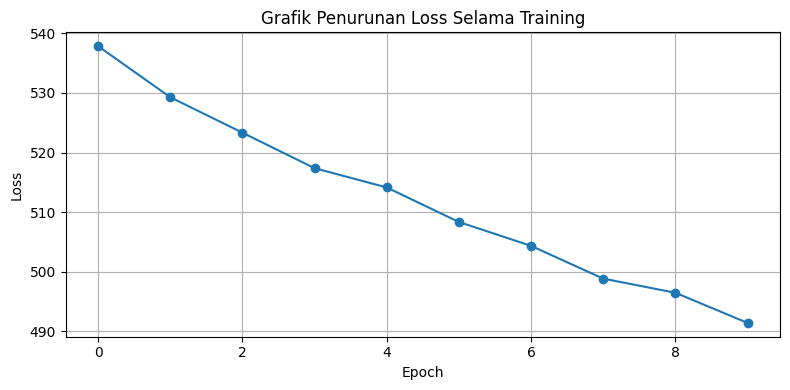

In [37]:
plt.figure(figsize=(8,4))
plt.plot(losses, marker='o')
plt.title("Grafik Penurunan Loss Selama Training")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.tight_layout()
plt.show()

### VISUALISASI REKONTRUKSI INPUT VS OUTPUT (Before vs After)

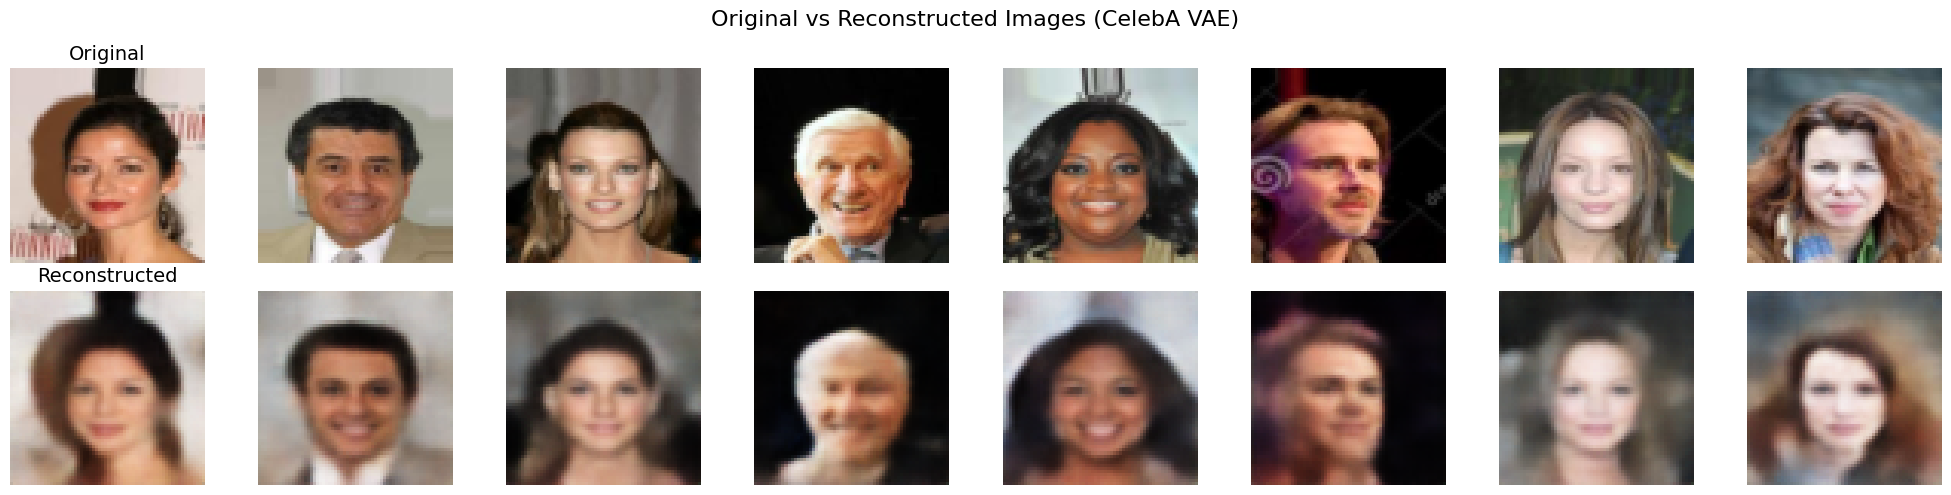

In [38]:
import matplotlib.pyplot as plt

vae.eval()
with torch.no_grad():
    sample = next(iter(dataloader))[0][:8].to(device)
    recon, _, _ = vae(sample)

sample = sample.cpu().numpy()
recon = recon.cpu().numpy()

fig, axes = plt.subplots(2, 8, figsize=(20, 5))
for i in range(8):
    # Original
    axes[0, i].imshow((sample[i].transpose(1, 2, 0) * 0.5 + 0.5).clip(0,1))
    axes[0, i].axis('off')
    # Reconstructed
    axes[1, i].imshow((recon[i].transpose(1, 2, 0) * 0.5 + 0.5).clip(0,1))
    axes[1, i].axis('off')

axes[0, 0].set_title('Original', fontsize=14)
axes[1, 0].set_title('Reconstructed', fontsize=14)
plt.suptitle('Original vs Reconstructed Images (CelebA VAE)', fontsize=16)
plt.tight_layout()
plt.show()

### VISUALISASI LATENT SPACE (PCA atau t-SNE)

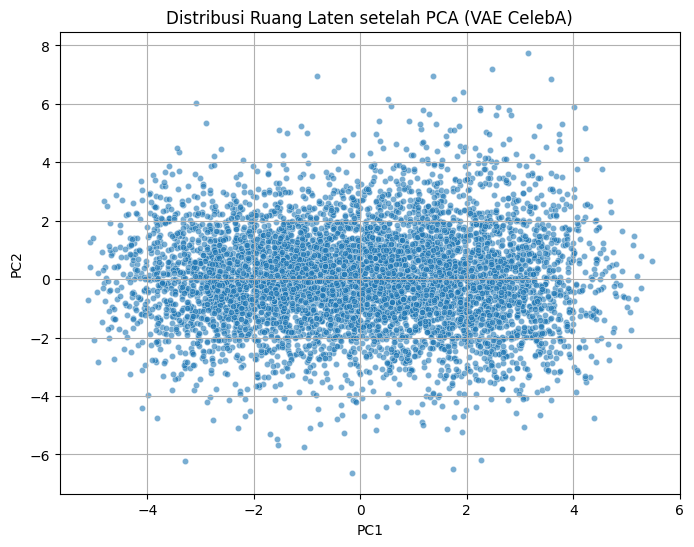

In [46]:
from sklearn.decomposition import PCA
import seaborn as sns
import numpy as np

vae.eval()
latent_vectors = []
with torch.no_grad():
    for batch in dataloader:
        x, _ = batch
        x = x.to(device)
        _, mu, _ = vae(x)  # langsung dari forward()
        latent_vectors.append(mu.cpu().numpy())


latent_vectors = np.concatenate(latent_vectors[:100])  # ambil 100 batch pertama
pca = PCA(n_components=2)
z_pca = pca.fit_transform(latent_vectors)

plt.figure(figsize=(8,6))
sns.scatterplot(x=z_pca[:,0], y=z_pca[:,1], s=20, alpha=0.6)
plt.title("Distribusi Ruang Laten setelah PCA (VAE CelebA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.show()

### VISUALISASI HASIL REKONTRUKSI

Muka Selebritis Asli:


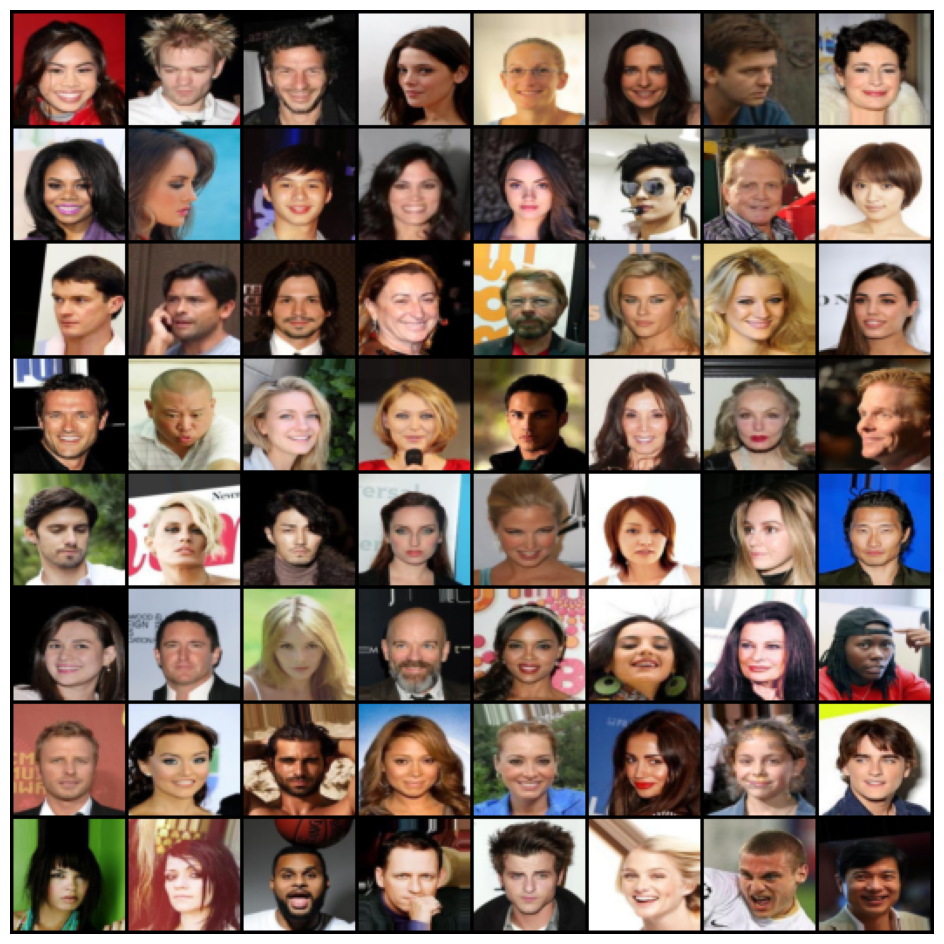

Rekonstruksi:


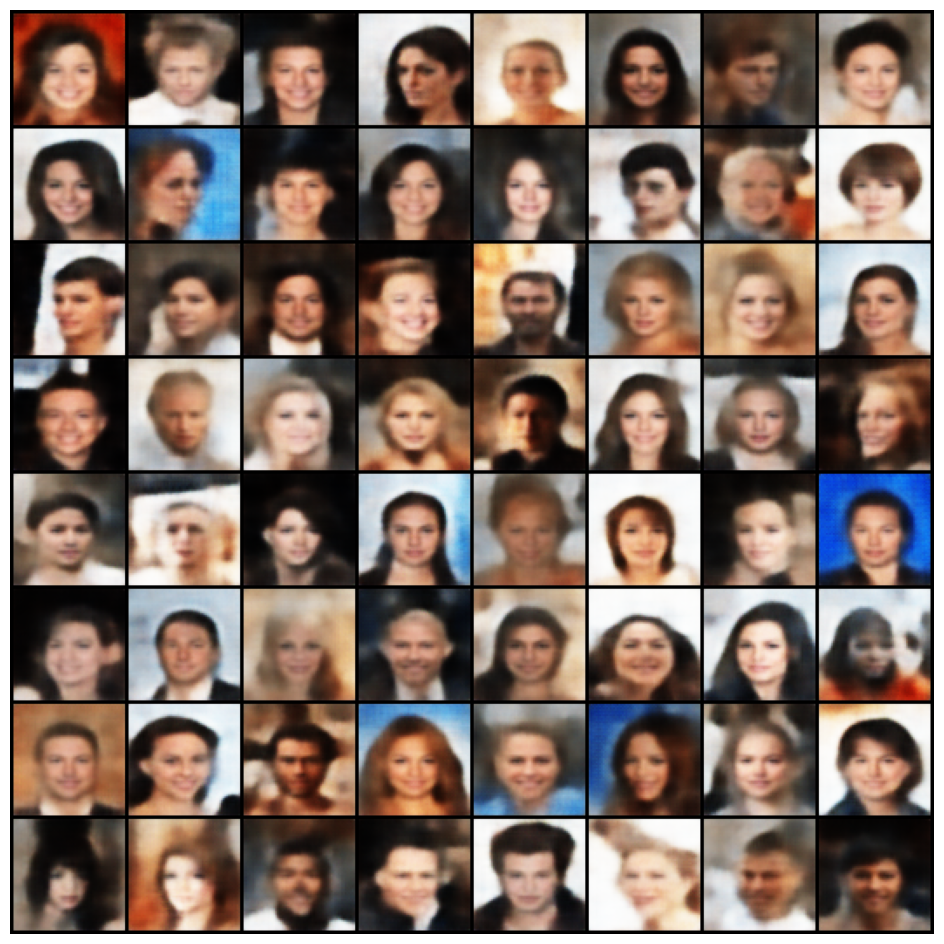

In [35]:
vae.eval()
with torch.no_grad():
    for batch in dataloader:
        x, _ = batch
        x = x.to(device)
        x_recon, _, _ = vae(x)
        break

# Unnormalize and display
def show_images(imgs):
    imgs = imgs * 0.5 + 0.5  # unnormalize
    grid = make_grid(imgs.cpu(), nrow=8)
    plt.figure(figsize=(12, 12))
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.show()

print("Muka Selebritis Asli:")
show_images(x)
print("Rekonstruksi:")
show_images(x_recon)